**Setup**

Importing modules

In [55]:
import pandas as pd
import re
import numpy as np
import sklearn
import imblearn
import sklearn.inspection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib

Reading in data

In [37]:
df_original = pd.read_csv('manga.csv', na_values = 'nan')

**Data Wrangling**

Handling missing values differently depending on the feature

In [38]:
updated_df_1 = df_original
updated_df_1["chapters"] = df_original["chapters"].fillna(value=-1)
updated_df_1["volumes"] = updated_df_1["volumes"].fillna(value=-1)


numeric_columns = df_original.select_dtypes(include=['number']).columns

updated_df_1 = df_original
updated_df_1[numeric_columns] = updated_df_1[numeric_columns].fillna(value=0)

Replacing individual demographic tag columns with a single label column to be used as the target feature.

In [39]:
demographic_labels = ["Shounen","Shoujo","Seinen","Josei"]
demo_only_df = updated_df_1.loc[:,demographic_labels]

# Finding instances with no clear demographic tag
total_pct_per_row = demo_only_df.sum(axis=1).tolist()
indices = [index for index, element in enumerate(total_pct_per_row) if element == 0]

# Finding best fit for each row, aside from no-tag cases
demo_column_1 = demo_only_df.idxmax(axis=1).tolist()
demo_column_2 = demo_column_1

# Replacing best fit demographic with "Unknown" in cases with no clear demographic tag
for index in indices:
    demo_column_2[index] = "Unknown"

# Adding column
updated_df_2 = updated_df_1
updated_df_2["Demographic"] = demo_column_2

# Removing demographic tag columns
updated_df_3 = updated_df_2.drop(demographic_labels, axis=1)

/tmp/ipykernel_17237/1673362650.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  updated_df_2["Demographic"] = demo_column_2


Recalculating status and score features; adding some additional calculated features

In [40]:
# Getting current list of columns
columns_list_v3 = updated_df_3.columns.tolist()

# Creating list of status columns only
status_regex = re.compile("status_")
status_raws_cols = list(filter(status_regex.match, columns_list_v3))

# Summing status columns only
popularity_list = updated_df_3[status_raws_cols].sum(axis=1).tolist()

# Adding new column
updated_df_4 = updated_df_3
updated_df_4["Popularity"] = popularity_list

# Recalculating statuses to be a percentage of popularity
for column in status_raws_cols:
    updated_df_4 = updated_df_4.assign(**{column: updated_df_4[column]/updated_df_4["Popularity"]})

# Renaming status columns to reflect their new meaning (this also renames score columns, which will be updated later)
updated_df_4.columns = updated_df_4.columns.str.replace("_count", "_pct", regex=False)

/tmp/ipykernel_17237/3582469316.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  updated_df_4["Popularity"] = popularity_list


In [41]:
# Getting current list of columns
columns_list_v4 = updated_df_4.columns.tolist()

# Creating list of score columns only
score_regex = re.compile("scored_")
score_raws_cols = list(filter(score_regex.match, columns_list_v4))

# Summing score columns only
score_list = updated_df_4[score_raws_cols].sum(axis=1).tolist()

# Adding new column
updated_df_5 = updated_df_4
updated_df_5["Scored_Percentage"] = score_list

# Recalculating statuses to be a percentage of popularity
for column in score_raws_cols:
    updated_df_5 = updated_df_5.assign(**{column: updated_df_5[column]/updated_df_5["Scored_Percentage"]})

updated_df_5 = updated_df_5.assign(Scored_Percentage = updated_df_5["Scored_Percentage"]/updated_df_5["Popularity"])

numeric_columns = updated_df_5.select_dtypes(include=['number']).columns
updated_df_5[numeric_columns] = updated_df_5[numeric_columns].fillna(value=0)

In [42]:
updated_df_6 = updated_df_5.assign(favorites = updated_df_5["favorites"]/updated_df_5["Popularity"])

Calculating a run length feature

In [43]:
updated_df_7 = updated_df_6.assign(run_length = updated_df_6["end_date_days"]-updated_df_6["start_date_days"])
updated_df_7["run_length"] = updated_df_7["run_length"].where(cond=updated_df_7["run_length"]>-1, other=-1)

In [44]:
updated_df_8 = updated_df_7.drop(["id", "eng_title", "rom_title","start_date","end_date"], axis=1)
updated_df_8 = pd.get_dummies(updated_df_8, dummy_na=True, columns=["status","source","country"])

**Balanced Random Forest Iterative Improvements**

Splitting into training and testing

In [45]:
training_df = updated_df_8.query("Demographic != 'Unknown'")
training_x = training_df.drop(columns=["Demographic"])
training_y = training_df[["Demographic"]]
testing_df = updated_df_8.query("Demographic == 'Unknown'")

Testing baseline classifier

In [56]:
rfBaseline = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=500, replacement=True, bootstrap=False, random_state=1234, sampling_strategy="all")
cross_validator = sklearn.model_selection.KFold(n_splits=10, shuffle=True, random_state=1234)
baseline_results = sklearn.model_selection.cross_val_score(rfBaseline, X=training_x, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
baseline_results.mean()

0.6091243759531286

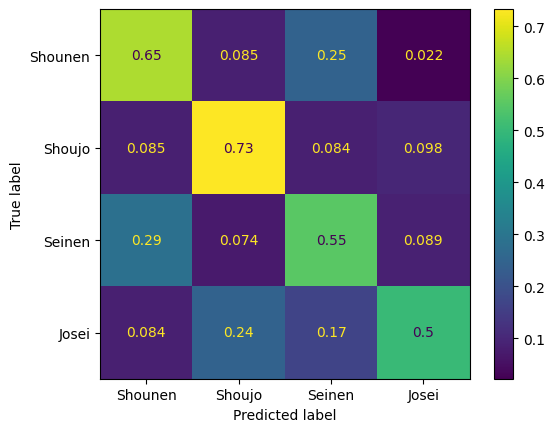

In [59]:
baseline_preds = sklearn.model_selection.cross_val_predict(rfBaseline, X=training_x, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= baseline_preds, labels=demographic_labels, normalize="true")

Removing highly correlated features

In [ ]:
temp = training_x.corr().stack().reset_index()
temp_2 = temp.rename(columns={"level_0":"first_var", "level_1":"second_var", 0:"correlation"}, inplace=False)
temp_2["correlation"] = temp_2["correlation"].abs()

temp_3 = temp_2.query("first_var != second_var").sort_values("correlation", ascending=False)

remvar = []
temp_vals = training_x

while temp_3.iloc[0,2] >= .8:
    remvar.append(temp_3.iloc[0,0])
    temp_vals = temp_vals.drop(remvar[-1], axis=1)
    temp_3 = temp_vals.corr().stack().reset_index().rename(columns={"level_0":"first_var", "level_1":"second_var", 0:"correlation"}).query("first_var != second_var")
    temp_3["correlation"] = temp_3["correlation"].abs()
    temp_3 = temp_3.sort_values("correlation", ascending=False)


Calculating variable importance using permutation, removing features that improve prediction by less than 1/20th of a percent; checking that results have not resulted in a dramatic reduction in prediction score

In [ ]:
rfPermutation = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=100, replacement=True, bootstrap=False, random_state=1234, sampling_strategy="all")
rfPermutation.fit(temp_vals, np.ravel(training_y))

permute_results = sklearn.inspection.permutation_importance(estimator=rfPermutation, X = temp_vals, y = training_y, scoring="recall_macro", n_repeats=3)

In [ ]:
perm_importance = pd.DataFrame()
perm_importance["feature"] = temp_vals.columns
perm_importance["importance"] = permute_results["importances_mean"]

In [ ]:
perm_features_tokeep = perm_importance.query("importance >= .00025").feature

refined_training = temp_vals[perm_features_tokeep]

rfReduced = imblearn.ensemble.BalancedRandomForestClassifier(n_estimators=500, oob_score = True, replacement=False, bootstrap=True, random_state=1234, sampling_strategy="all")

reduced_cv_results = sklearn.model_selection.cross_val_score(rfReduced, X=refined_training, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
reduced_cv_results.mean()

0.6011272752085196

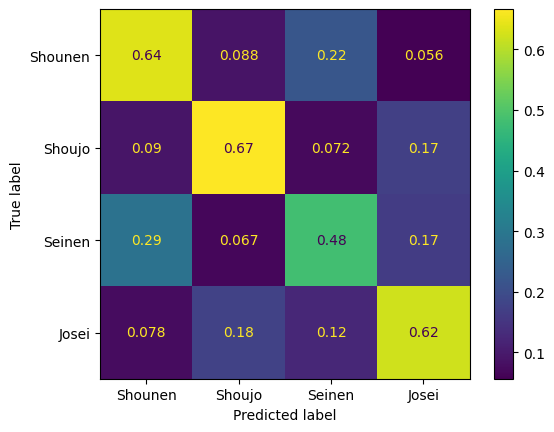

In [60]:
permutation_predictions = sklearn.model_selection.cross_val_predict(rfReduced, X=refined_training, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= permutation_predictions, labels=demographic_labels, normalize="true")

Performing randomized search to tune hyperparameters, testing scoring results

In [ ]:
hyperparameter_dict = {"criterion": ["gini", "entropy"],
                       "max_depth": [None, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60],
                       "min_samples_split": [2, 3, 4, 5, 7, 10, 15],
                       "min_samples_leaf": [1, 2, 4, 5],
                       "sampling_strategy": ["majority", "not minority", "not majority", "all"],
                       "class_weight": [None, "balanced", "balanced_subsample"]
                       }

RandomSearchrf = imblearn.ensemble.BalancedRandomForestClassifier(bootstrap=False, replacement=True, random_state=1234, n_estimators=500)

rf_random = sklearn.model_selection.RandomizedSearchCV(estimator = RandomSearchrf, param_distributions = hyperparameter_dict, n_iter = 25, cv = 3, verbose=2, random_state=1234, scoring="recall_macro")

randsearch_output = rf_random.fit(refined_training, np.ravel(training_y))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   2.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   2.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   2.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   4.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   3.9s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   3.7s
[CV] END class_weight=None, criterion=gini, max_depth=60, min_samples_leaf=5, min

In [ ]:
randsearch_output.best_estimator_

BalancedRandomForestClassifier(bootstrap=False,
                               class_weight='balanced_subsample',
                               criterion='entropy', max_depth=40,
                               min_samples_leaf=5, min_samples_split=4,
                               n_estimators=500, random_state=1234,
                               replacement=True, sampling_strategy='all')

In [ ]:
xvalidated_classifier = randsearch_output.best_estimator_

xvalidated_classifier.get_params()["n_estimators"] = 10000

optimal_model_results = sklearn.model_selection.cross_val_score(xvalidated_classifier, X=refined_training, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
optimal_model_results.mean()

0.577155908655705

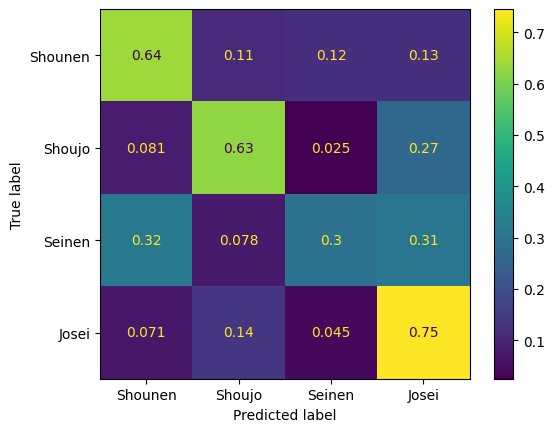

In [61]:
hyperparam_tuned_predictions = sklearn.model_selection.cross_val_predict(xvalidated_classifier, X=refined_training, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= hyperparam_tuned_predictions, labels=demographic_labels, normalize="true")

Checking reduced

**Regular Random Forest Iterative Approach**

In [ ]:
# modified df baseline normal
# permute, check again
# hyperparameter tuning
# cross validate best hyperparameter

Checking baseline results of model

In [ ]:
BaselineNonbalancedrf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=1234)

baseline_results_unbalanced = sklearn.model_selection.cross_val_score(BaselineNonbalancedrf, X=training_x, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
baseline_results_unbalanced.mean()

0.5515141899218475

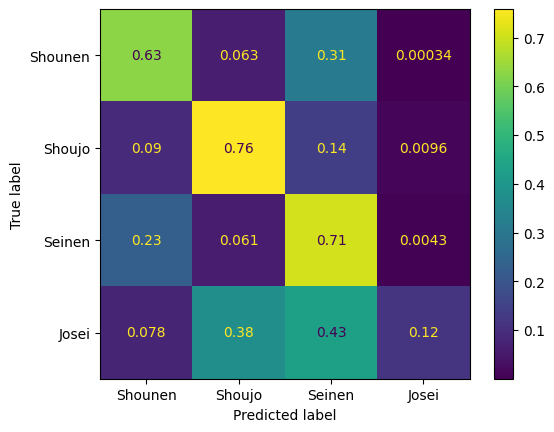

In [62]:
baseline_nonbalanced_preds = sklearn.model_selection.cross_val_predict(BaselineNonbalancedrf, X=training_x, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= baseline_nonbalanced_preds, labels=demographic_labels, normalize="true")

Removing features using permutation (this time using a wider threshold for retaining features due to relatively low average feature importance); testing new score

In [ ]:
rfPermutation_unbalanced = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=1234)
rfPermutation_unbalanced.fit(temp_vals, np.ravel(training_y))

permute_results_imbalanced = sklearn.inspection.permutation_importance(estimator=rfPermutation_unbalanced, X = temp_vals, y = training_y, scoring="recall_macro", n_repeats=3)

perm_importance_imbalanced = pd.DataFrame()
perm_importance_imbalanced["feature"] = temp_vals.columns
perm_importance_imbalanced["importance"] = permute_results_imbalanced["importances_mean"]


perm_features_tokeep_imbalanced = perm_importance_imbalanced.query("importance >= .00025").feature

refined_training_imbalanced = temp_vals[perm_features_tokeep_imbalanced]

rfReduced_imbalanced = sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=1234)

reduced_cv_results = sklearn.model_selection.cross_val_score(rfReduced_imbalanced, X=refined_training_imbalanced, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
reduced_cv_results.mean()

0.5569071836295285

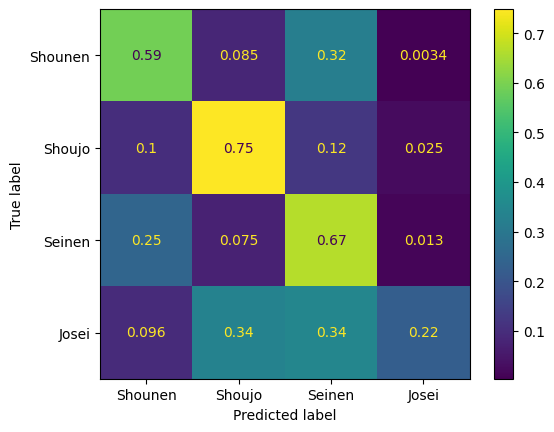

In [63]:
permutation_imbalanced_predictions = sklearn.model_selection.cross_val_predict(rfReduced_imbalanced, X=refined_training_imbalanced, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= permutation_imbalanced_predictions, labels=demographic_labels, normalize="true")

Performing randomized search to tune hyperparameters, testing scoring results

In [ ]:
hyperparameter_dict_imbalanced = {"criterion": ["gini", "entropy"],
                       "max_depth": [None, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60],
                       "min_samples_split": [2, 3, 4, 5, 7, 10, 15],
                       "min_samples_leaf": [1, 2, 4, 5],
                       "class_weight": [None, "balanced", "balanced_subsample"]
                       }


RandomSearchrf_imbalanced = sklearn.ensemble.RandomForestClassifier(random_state=1234, n_estimators=500)

rf_random_imbalanced = sklearn.model_selection.RandomizedSearchCV(estimator = RandomSearchrf_imbalanced, param_distributions = hyperparameter_dict_imbalanced, n_iter = 25, cv = 3, verbose=2, random_state=1234, scoring="recall_macro")

randsearch_output_imbalanced = rf_random.fit(refined_training_imbalanced, np.ravel(training_y))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   1.8s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   1.7s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3, sampling_strategy=all; total time=   1.7s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   3.1s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   3.1s
[CV] END class_weight=None, criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=10, sampling_strategy=all; total time=   3.0s
[CV] END class_weight=None, criterion=gini, max_depth=60, min_samples_leaf=5, min

In [ ]:
xvalidated_classifier_imbalanced = randsearch_output_imbalanced.best_estimator_

xvalidated_classifier_imbalanced.get_params()["n_estimators"] = 10000

optimal_model_results_imbalanced = sklearn.model_selection.cross_val_score(xvalidated_classifier_imbalanced, X=refined_training_imbalanced, y=np.ravel(training_y), groups=None, scoring="recall_macro",cv=cross_validator)
optimal_model_results_imbalanced.mean()

0.5664868421713005

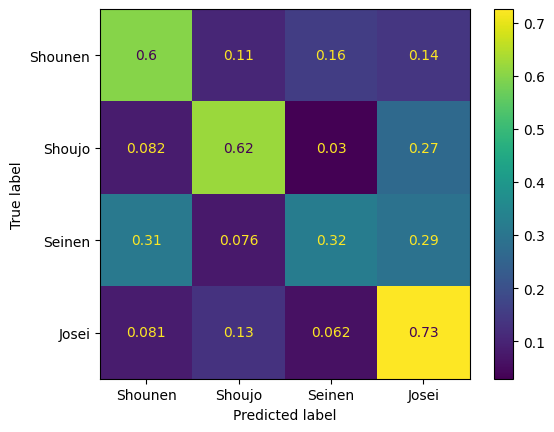

In [64]:
imbalanced_hyperparam_tuned_predictions = sklearn.model_selection.cross_val_predict(xvalidated_classifier_imbalanced, X=refined_training_imbalanced, y=np.ravel(training_y), cv=cross_validator)

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true = np.ravel(training_y), y_pred= imbalanced_hyperparam_tuned_predictions, labels=demographic_labels, normalize="true")